The objective is to pool all the ARM ocean data together and obtain a collective precipitation buoyancy relationship

In [2]:
import pathlib
import importlib

In [27]:
import Process_ARM
importlib.reload(Process_ARM)
from Process_ARM import ProcessARM

Give file locations

In [28]:
arm_path = pathlib.Path('/neelin2020/ARM/')
arm_files = dict(TWPC1 = arm_path / 'TWPC1',
                TWPC2 = arm_path / 'TWPC2',
                TWPC3 = arm_path / 'TWPC2')

In [29]:
twpc1 = ProcessARM(arm_files['TWPC1'])
twpc1.files

['/neelin2020/ARM/TWPC1/twparmbeatmC1.c1.19960101.000000.cdf',
 '/neelin2020/ARM/TWPC1/twparmbeatmC1.c1.19970101.000000.cdf',
 '/neelin2020/ARM/TWPC1/twparmbeatmC1.c1.19980101.000000.cdf',
 '/neelin2020/ARM/TWPC1/twparmbeatmC1.c1.19990101.000000.cdf',
 '/neelin2020/ARM/TWPC1/twparmbeatmC1.c1.20000101.000000.cdf',
 '/neelin2020/ARM/TWPC1/twparmbeatmC1.c1.20010101.000000.cdf',
 '/neelin2020/ARM/TWPC1/twparmbeatmC1.c1.20020101.000000.cdf',
 '/neelin2020/ARM/TWPC1/twparmbeatmC1.c1.20030101.000000.cdf',
 '/neelin2020/ARM/TWPC1/twparmbeatmC1.c1.20040101.000000.cdf',
 '/neelin2020/ARM/TWPC1/twparmbeatmC1.c1.20050101.000000.cdf',
 '/neelin2020/ARM/TWPC1/twparmbeatmC1.c1.20060101.000000.cdf',
 '/neelin2020/ARM/TWPC1/twparmbeatmC1.c1.20070101.000000.cdf',
 '/neelin2020/ARM/TWPC1/twparmbeatmC1.c1.20080101.000000.cdf',
 '/neelin2020/ARM/TWPC1/twparmbeatmC1.c1.20090101.000000.cdf',
 '/neelin2020/ARM/TWPC1/twparmbeatmC1.c1.20100101.000000.cdf']

In [6]:
import xarray as xr
import matplotlib.pyplot as plt
from glob import glob
import os
# from vert_cython import find_closest_index_2D, compute_layer_thetae
from thermodynamic_functions import qs_calc
import numpy as np
# from numba import jit
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import pytz
import matplotlib.ticker as ticker


%matplotlib inline

Include thermodynamic and dynamic variables

In [7]:
ta={}
hus={}
ps={}
pr={}
qsat={}
uwind={}
vwind={}

In [7]:
!ls /neelin2020/ARM/
# xr.open_dataset('/neelin2020/ARM/TWPC3/')  

CACTI  GoAmazon  SGP  TWPC1  TWPC2  TWPC3


In [8]:
for key in ['TWPC1','TWPC2','TWPC3']:

    print(key)
    dir_in='/neelin2020/ARM/'+key+'/'
    fil_in=glob(dir_in+'twparmbeatm*cdf')
    fil_in.sort()

    ds=xr.open_mfdataset(fil_in)
    print(ds)
    break
    temp=ds.T_p.load()
    temp_dp=ds.Td_p.load()
    temp=temp.dropna(dim='time')
    temp_dp=temp_dp.dropna(dim='time')
    prc=ds.prec_sfc.load()

    temp_new=temp.where(temp.time.isin(temp_dp.time), drop=True)
    temp_dp_new=temp_dp.sel(time=temp_new.time)
    prc_new=prc.sel(time=temp_new.time)
    prc_new=prc_new.dropna(dim='time')

    temp_new=temp_new.sel(time=prc_new.time)
    temp_dp_new=temp_dp_new.sel(time=prc_new.time)

    psurf=ds.p_sfc.load()*1e2 # convert to Pa
    psurf=psurf.sel(time=temp_new.time)
    psurf=psurf.dropna(dim='time')

    ta[key]=temp_new.sel(time=psurf.time)
    temp_dp_new=temp_dp_new.sel(time=psurf.time)
    pr[key]=prc_new.sel(time=psurf.time)
    ps[key]=psurf

    qsat[key]=qs_calc(temp.p,ta[key])
    hus[key]=qs_calc(temp_dp.p,temp_dp_new)
    u_p=ds.u_p.load()
    v_p=ds.v_p.load()
    uwind[key]=u_p.sel(time=psurf.time)
    vwind[key]=v_p.sel(time=psurf.time)
    
    ds.close()
    

TWPC1


/home/fiaz/anaconda3/envs/aos112/lib/python3.8/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


KeyboardInterrupt: 

Join arrays

In [4]:
return_list=lambda x: [x[key] for key in x.keys()]
def merge_arrays(x):
    array_list=return_list(x)
    return xr.concat(array_list,dim='time')

In [5]:
temp_pooled,hus_pooled,qsat_pooled,pr_pooled,ps_pooled=list(map(merge_arrays,[ta,hus,qsat,pr,ps]))
uwind_pooled,vwind_pooled=list(map(merge_arrays,[uwind,vwind]))

In [6]:
pbl_top=ps_pooled-100e2 ## The BL is 100 mb thick ##
pbl_top=np.float_(pbl_top.values.flatten()) ### overwriting pbl top xarray with numpy array
## setting the pressure level at the top of a nominal lower free troposphere (LFT)
low_top=np.zeros_like(ps_pooled)
low_top[:]=500e2  # the LFT top is fixed at 500 mb
low_top=np.float_(low_top.flatten())

In [7]:
pbl_ind=np.zeros(pbl_top.size,dtype=np.int64)
low_ind=np.zeros(low_top.size,dtype=np.int64)

In [8]:
# pres,dummy=xr.broadcast(temp.lev,da.isel(lev=0,drop=True))
lev,dummy=xr.broadcast(temp_pooled.p,temp_pooled)
lev=lev*100
lev=lev.astype('float')

In [9]:
### Find the closest pressure level to pbl_top and low_top
### using a cython routine 'find_closest_index_2D'
find_closest_index_2D(pbl_top,lev.values,pbl_ind)
find_closest_index_2D(low_top,lev.values,low_ind)

Compute layer theta_e values

In [10]:
thetae_bl=np.zeros_like(pbl_top)
thetae_lt=np.zeros_like(pbl_top)
thetae_sat_lt=np.zeros_like(pbl_top)
wb=np.zeros_like(pbl_top)


ta_flat=np.asarray(temp_pooled.values,dtype='float')
hus_flat=np.asarray(hus_pooled.values,dtype='float')

In [11]:
compute_layer_thetae(ta_flat.T, hus_flat.T, lev.values, 
                     pbl_ind, low_ind, thetae_bl, thetae_lt, thetae_sat_lt, wb)

In [67]:
cape=(thetae_bl-thetae_sat_lt)*340./thetae_sat_lt
subsat=(thetae_sat_lt-thetae_lt)*340./thetae_sat_lt
gravity=9.8
bl=(gravity/340.)*(wb*cape-(1-wb)*subsat)

# # plt.plot(cape[prc_new>0.25])
# plt.plot(subsat[pr_pooled>0.25])
# ind=np.where(np.logical_and(thetae_bl>350,thetae_bl<355))
# # ind=np.where(np.logical_or(thetae_bl<350,thetae_bl>355))
# ind=np.where(thetae_bl>340)
# ind=np.where(temp_LFT>286)

# cape=cape[ind]
# subsat=subsat[ind]
bl.min()

-1.0631749275926201

Conditionally average

In [15]:
# @jit(nopython=True)
def precipbuoy_binThetae(PRECIP_THRESHOLD, NUMBER_CAPE_BIN, NUMBER_SUBSAT_BIN,
NUMBER_BL_BIN, CAPE, SUBSAT, BL, rain, p0, p1, p2, pe, q0, q1, q2, qe):

    
    for time_idx in np.arange(SUBSAT.shape[0]):
        if (CAPE[time_idx]<NUMBER_CAPE_BIN and CAPE[time_idx]>=0
        and SUBSAT[time_idx]<NUMBER_SUBSAT_BIN and SUBSAT[time_idx]>=0
        and np.isfinite(rain[time_idx])):
            p0[SUBSAT[time_idx],CAPE[time_idx]]+=1
            p1[SUBSAT[time_idx],CAPE[time_idx]]+=rain[time_idx]
            p2[SUBSAT[time_idx],CAPE[time_idx]]+=rain[time_idx]**2

            if (rain[time_idx]>PRECIP_THRESHOLD):
                pe[SUBSAT[time_idx],CAPE[time_idx]]+=1

        
        if (BL[time_idx]<NUMBER_BL_BIN and BL[time_idx]>=0
        and np.isfinite(rain[time_idx])):
            q0[BL[time_idx]]+=1
            q1[BL[time_idx]]+=rain[time_idx]
            q2[BL[time_idx]]+=rain[time_idx]**2
            if (rain[time_idx]>PRECIP_THRESHOLD):
                qe[BL[time_idx]]+=1

Set bin parameters

In [16]:
bl_bin_params={}
bl_bin_params['width']=0.02
bl_bin_params['max']=.50
bl_bin_params['min']=-1.5

# Bin width and intervals for CAPE and SUBSAT.
# In units of K
cape_params_list=[2,20,-40]
subsat_params_list=[2,42,-1]

cape_bin_params={key: value for key,value in zip(bl_bin_params.keys(),cape_params_list)}
subsat_bin_params={key: value for key,value in zip(bl_bin_params.keys(),subsat_params_list)}

In [18]:
### Get indices ###
SUBSAT=(subsat-subsat_bin_params['min'])/subsat_bin_params['width']-0.5
SUBSAT=SUBSAT.astype(int)

CAPE=(cape-cape_bin_params['min'])/cape_bin_params['width']-0.5
CAPE=CAPE.astype(int)

BL=(bl-bl_bin_params['min'])/(bl_bin_params['width'])+0.5
BL=BL.astype(int)

RAIN=pr_pooled.values
# RAIN=RAIN[ind]

###################

generate_bin_center = lambda x: np.arange(x['min'],x['max']+x['width'],x['width'])

cape_bin_center=generate_bin_center(cape_bin_params)
subsat_bin_center=generate_bin_center(subsat_bin_params)
bl_bin_center=generate_bin_center(bl_bin_params)

NUMBER_CAPE_BIN=cape_bin_center.size
NUMBER_SUBSAT_BIN=subsat_bin_center.size
NUMBER_BL_BIN=bl_bin_center.size

# Allocate arrays for 2D binning (CAPE, SUBSAT)
P0=np.zeros((NUMBER_SUBSAT_BIN,NUMBER_CAPE_BIN))
P1=np.zeros((NUMBER_SUBSAT_BIN,NUMBER_CAPE_BIN))
P2=np.zeros((NUMBER_SUBSAT_BIN,NUMBER_CAPE_BIN))
PE=np.zeros((NUMBER_SUBSAT_BIN,NUMBER_CAPE_BIN))

# Allocate arrays for 1D binning (BL)

Q0=np.zeros((NUMBER_BL_BIN))
Q1=np.zeros((NUMBER_BL_BIN))
Q2=np.zeros((NUMBER_BL_BIN))
QE=np.zeros((NUMBER_BL_BIN))

In [20]:
PRECIP_THRESHOLD=0.25
precipbuoy_binThetae(PRECIP_THRESHOLD,
NUMBER_CAPE_BIN, NUMBER_SUBSAT_BIN, NUMBER_BL_BIN,
CAPE, SUBSAT, BL, RAIN, P0, P1, P2, PE, Q0, Q1, Q2, QE)

Compute wind shear

In [73]:
BL_dil_bins=np.arange(-0.1,0.2,0.0075)*340.#[::-1]
BL_NE_bins=np.arange(-0.1,0.2,0.0075)*340.
BL_bins=np.arange(-0.3,0.21,0.02)

def bin_pr_2D(x,y,pr,
              xbins,ybins):
    pr_conditional_mean=np.zeros((xbins.size,ybins.size))
    xcounts=np.zeros_like(pr_conditional_mean)
    xindex=np.int_((x-xbins[0])/np.diff(xbins)[0])
    yindex=np.int_((y-ybins[0])/np.diff(ybins)[0])
    
    for i in range(xbins.size):
        for j in range(ybins.size):
            ind=np.where(np.logical_and(xindex==i,yindex==j))[0]
            pr_conditional_mean[i,j]=pr[ind].mean() if ind.size>0 else np.nan
            xcounts[i,j]=ind.size   
    pr_conditional_mean=np.ma.masked_where(xcounts<15,pr_conditional_mean)
    
    return pr_conditional_mean,xcounts


def bin_pr_1D(x,pr,xbins):
    pr_conditional_mean=np.zeros((xbins.size))
    xcounts=np.zeros_like(pr_conditional_mean)
    std_err=np.zeros_like(pr_conditional_mean)
    tcounts=np.zeros_like(pr_conditional_mean)

    xindex=np.int_((x-xbins[0])/np.diff(xbins)[0])
    for i in range(xbins.size):
        ind=np.where(xindex==i)[0]
        pr_conditional_mean[i]=pr[ind].mean() if ind.size>0 else np.nan
        xcounts[i]=ind.size    
        std_err[i]=np.nanstd(pr[ind])/np.sqrt(ind.size)
        tcounts[i]=pr[ind][pr[ind]>0.1].size    
    pr_conditional_mean=np.ma.masked_where(xcounts<20,pr_conditional_mean)
    
    return pr_conditional_mean,xcounts,tcounts,std_err


# subsat=ds_plume.BL_NE.values-ds_plume.BL.values
# cape=ds_plume.BL_NE.values


pr_conditional_mean_2D,BL_counts_2D=bin_pr_2D(subsat,cape,pr_pooled,
                                              BL_dil_bins,BL_NE_bins)

pr_conditional_mean_1D,BL_counts_1D,BL_pcp_counts_1D,std_err=bin_pr_1D(bl,pr_pooled,
                                              BL_bins)



/home/fiaz/anaconda3/envs/aos112/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [74]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('gist_ncar')
new_cmap = truncate_colormap(cmap, 0.1, 0.8)

<ipython-input-77-1bb07028a416>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  CT=ax.pcolormesh(BL_dil_bins,BL_NE_bins,pr_conditional_mean_2D.T,


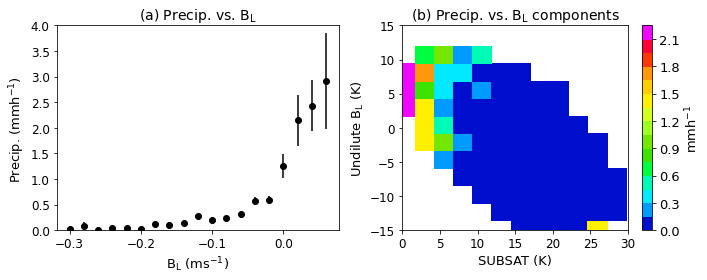

In [77]:
levels = MaxNLocator(nbins=15).tick_values(0, 
                                           2.2)
gravity=9.8
factor=340./gravity

# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('gist_ncar')
# cmap=cmap(np.linspace(0.2, 0.8, 100))
norm = BoundaryNorm(levels, ncolors=new_cmap.N, clip=True)

fig,axx=plt.subplots(1,2,figsize=(10,4))

ax=axx[1]
CT=ax.pcolormesh(BL_dil_bins,BL_NE_bins,pr_conditional_mean_2D.T,
               cmap=new_cmap,norm=norm)
ax.tick_params(which='both',
              labelsize=12)
ax.set_ylim(bottom=-15,top=15.)
ax.set_xlim(left=0.,right=30)
ax.set_ylabel('Undilute $\mathrm{B_L}$ (K)',fontsize=13)
ax.set_xlabel('SUBSAT (K)',fontsize=13)
ax.set_title('(b) Precip. vs. $\mathrm{B_L}$ components',fontsize=14)
cb=plt.colorbar(CT)
cb.ax.tick_params(which='both',labelsize=13)
cb.set_label(label='$\mathrm{mmh^{-1}}$',size=13)

ax=axx[0]

# ax.scatter(BL_bins,pr_conditional_mean_1D)
ax.errorbar(BL_bins,pr_conditional_mean_1D,std_err,fmt='o',c='black')
ax.tick_params(which='both',
              labelsize=12)
ax.set_xlabel('$\mathrm{B_L}\ (\mathrm{ms^{-1}})$',fontsize=13)
ax.set_ylabel('Precip. $(\mathrm{mmh^{-1}})$ ',fontsize=13)
ax.set_title('(a) Precip. vs. $\mathrm{B_L}$',fontsize=14)

ax.set_ylim(bottom=0,top=4)

## set plot directory
plt_dir='/home/fiaz/DOE_ASR_2022/plots/'
plt.tight_layout()

SAVE=False
if SAVE:
    plt.savefig(plt_dir+'P_BL_components_ARM_oceans.pdf',format='pdf',
               bbox_inches='tight')
